In [1]:
    
from pathlib import Path
import numpy as np
from gauss_newton_math import *
from systems import *
from utils import plot_solution
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
import time as tm_module
import jax.numpy as jnp
import jax


In [2]:
from matplotlib.gridspec import GridSpec

def prepare_sintetic_data(system: SystemJacobian, c0, theta, time_intervals):
    def generate_sintetic_data(
        system,
        c0_true,
        theta_true,
        t_s = 0,
        t_f = 8,
        N_measurement = 200,
        sigma = 1e-3):

        t_eval_measurements = np.linspace(t_s, t_f, N_measurement) 
        solution = system.get_solution_jax(c0_true, theta_true, t_eval_measurements)
        
        #state_full = solution[1][0:STATE_LENGTH] +  (np.random.random(solution[1][0:STATE_LENGTH].shape) - 0.5)*sigma
        return t_eval_measurements, solution.T

    STATE_LENGTH, THETA_LENGTH, MEAS_LEN = system.get_dimentions()
    assert len(c0) == STATE_LENGTH
    assert len(theta) == THETA_LENGTH

    state_measured_batches = []
    state_full_batches = []
    t_eval_measurements_batches = []

    for (t_s, t_f) in time_intervals:
        t_eval_measurements, state_full  = generate_sintetic_data(system, c0_true=c0*(1 + 0*(np.random.random() - 0.5)) , N_measurement = 200, theta_true = theta, t_s = t_s, t_f = t_f, sigma = 0.0001)
        state_measured = np.zeros((len(state_full), MEAS_LEN))
        for i, state in enumerate(state_full):
            state_measured[i] = system.h_x(state, t_eval_measurements[i], theta)
        
        t_eval_measurements_batches.append(t_eval_measurements)
        state_measured_batches.append(state_measured)
        state_full_batches.append(state_full)
    return t_eval_measurements_batches, state_measured_batches, state_full_batches


    

In [ ]:

VALIDATION = 0

N_shoot = 5
N_iter = 7


if (0):
    class MyLotka_voltera(Lotka_voltera):
        def observation(self):
            x, y = self.state
            observed = vertcat(x)
            return observed 
        
    sym_object = MyLotka_voltera()

    theta_true = np.array([1.2, 0.4, 0.3, 0.1])
    c0 = np.array([6, 5]) 
    delta_theta = np.array([0.2, -0.11, 0.05, 0.01]) * 0.8 + (np.random.rand(4)-0.5)*0.05
    theta = theta_true + delta_theta
elif(1):
    class Shuttle_Dynamic(Lateral_car_dynamic):
        def get_input_signals(self, t):
            w = 0.7
            u = 0.04 * jnp.cos(t*0.25*w) * jnp.sin(w*t)
            return [u, 10.0]
        
        def observation(self):
            vy, wz = self.state
            observed = vertcat(wz)
            #observed = vertcat(wz, vy)
            return observed 
        
    sym_object = Shuttle_Dynamic()
    theta_true = np.array([ 3.90697911, -3.61844364, 11.46438743, 10.16318852])
    theta = theta_true*0.0 + (np.random.rand(4)-0.5)*10
    c0 = np.array([0, 0]) 
elif(0):
    sym_object = Attractor()
    theta_true = np.array([0.14, 0.3, 0.4])
    theta = theta_true * 1.5
    c0 = np.array([1, 2, 1.2])   
    
system = SystemJacobian(sym_object)

In [120]:

t_eval_measurements_batches, state_measured_batches, state_full_batches = prepare_sintetic_data(system, c0, theta_true, [(0, 100)])

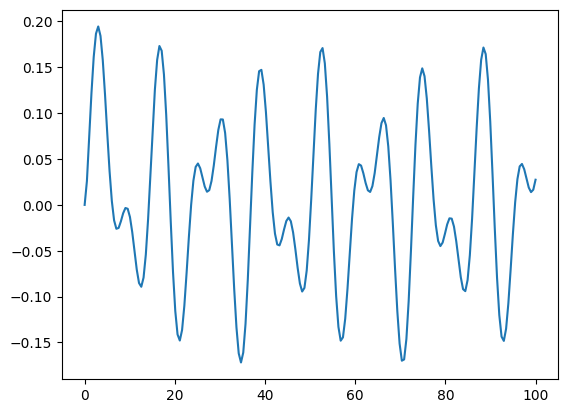

In [121]:
for t_batch, meas_batch, fill_batch in zip(t_eval_measurements_batches, state_measured_batches, state_full_batches):
    plt.plot(t_batch, meas_batch)

In [122]:

def plot_solution(problem: MultipleShooting, theta_full: np.array, THETA_HIST, validation = False):    
    k = len(problem.t_eval_measurements_batches)
    fig = plt.figure(figsize=(30, 15))
    gs = GridSpec(4, k, figure=fig, hspace = 0.2, wspace = 0.1)
    if(1):
        ax1 = fig.add_subplot(gs[0, :])
        ax1.legend()
        ax1.grid(True)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')

    ax2 = fig.add_subplot(gs[3, :])
    axes_f = []
    axes_s = []
    for i in range(len(problem.state_measured_batches)):
        ax = fig.add_subplot(gs[1, i])
        ax.grid(True)
        ax.set_xlabel('time, s')
        ax.set_ylabel('x')
        axes_f.append(ax)
        
        ax = fig.add_subplot(gs[2, i])
        ax.set_xlabel('time, s')
        ax.set_ylabel('y')
        ax.grid(True)
        axes_s.append(ax)
        
    for batch, (state_full, state_measured, t_eval_measurements) in \
                                        enumerate(zip(problem.state_full_batches, 
                                                      problem.state_measured_batches, 
                                                      problem.t_eval_measurements_batches)):
        print(f'batch {batch}')
        N_measurement = len(t_eval_measurements)
        measurement_indexes = np.arange(0, N_measurement, 1, dtype=int )
        shoot_indexes = measurement_indexes[0:-1:int(len(measurement_indexes)/problem.N_shoot)]
        shoot_indexes = np.append(shoot_indexes, measurement_indexes[-1])
        STATE_LENGTH, THETA_LENGTH, MEAS_LEN = problem.system.get_dimentions()
        for shoot in range(min(len(shoot_indexes) -1, 100)):
            print(f'shoot {shoot}')
            if(validation):
                c0 = state_full[shoot_indexes[shoot]]
                time_manger = TimeIntervalManager(problem.N_shoot, t_eval_measurements)
                t_eval_curr,  _  = time_manger.get_time_interval(shoot)
            else:
                c0 = theta_full[THETA_LENGTH + (problem.N_shoot) * batch * STATE_LENGTH + shoot * STATE_LENGTH : THETA_LENGTH + (problem.N_shoot) * batch * STATE_LENGTH +  (shoot + 1) * STATE_LENGTH]
                t_eval_curr, _ = problem.get_time_interval(shoot, batch)
                

            solution = problem.system.get_solution_jax(c0, theta_full[:THETA_LENGTH], t_eval_curr)
            state_observed = np.zeros((solution.T.shape[0], 2))
            for i, state in enumerate(solution.T):
                state_observed[i] = state  #system.h_x(state,  t_eval_curr[i], theta_full[:THETA_LENGTH])

            axes_f[batch].plot(t_eval_curr, state_observed[:, 0])
            if(state_observed.shape[1] > 1):
                ax1.plot(state_observed[:, 0], state_observed[:, 1])
                axes_s[batch].plot(t_eval_curr, state_observed[:, 1])
        

        axes_f[batch].scatter(t_eval_measurements, state_full[:, 0],  color='green',  marker='x',  s=1)
        axes_s[batch].scatter(t_eval_measurements, state_full[:, 1],  color='green',  marker='x')

        if(state_measured.shape[1] > 1):
            ax1.scatter(state_measured[:, 0] , state_measured[:, 1], color='green',  marker='x')
        

    plt.tight_layout()
    data = np.array(THETA_HIST)[:, :THETA_LENGTH]
    ax2.plot(range(len(data)), data)
    ax2.set_xlabel('iter')
    ax2.legend()
    ax2.grid(True)
    plt.show()

In [123]:
class Constrainth:
    def __init__(self, coefs):
        self.G = []
        self.h = []
        self.coefs = coefs

    def add(self, index, min_val, max_val):
        G_new = np.zeros((2, len(self.coefs)))
        G_new[0][index] = -1
        G_new[1][index] = 1
        h_new = np.zeros(2)
        h_new[0] = -(min_val - self.coefs[index])
        h_new[1] = (max_val - self.coefs[index])
        if(len(self.G)):
            self.G = np.vstack((self.G, G_new))
            self.h = np.hstack((self.h, h_new))
        else:
            self.G = G_new
            self.h = h_new

    def get_matrix(self):
        return self.G, self.h
    

0 solve batch {batch}
t solve 2.5649101734161377
     pcost       dcost       gap    pres   dres
 0: -3.3712e+00 -2.1672e+02  2e+02  9e-15  1e-14
 1: -5.1015e+00 -1.8959e+01  1e+01  3e-15  1e-14
 2: -1.0175e+01 -1.2661e+01  2e+00  4e-15  9e-15
 3: -1.0972e+01 -1.1255e+01  3e-01  3e-15  2e-15
 4: -1.1102e+01 -1.1144e+01  4e-02  2e-15  2e-15
 5: -1.1124e+01 -1.1129e+01  6e-03  5e-16  3e-16
 6: -1.1128e+01 -1.1128e+01  5e-04  6e-16  4e-16
 7: -1.1128e+01 -1.1128e+01  7e-06  1e-16  2e-16
Optimal solution found.
Iter 0   --- R 4.718482466921809
0 solve batch {batch}
t solve 0.03452754020690918
     pcost       dcost       gap    pres   dres
 0:  3.7255e+00 -2.0179e+02  2e+02  9e-14  2e-13
 1:  3.2506e+00 -5.2897e+00  9e+00  4e-14  7e-14
 2:  4.9801e-01 -9.4741e-01  1e+00  4e-14  4e-14
 3:  3.6737e-02 -1.3074e-01  2e-01  2e-14  2e-14
 4: -3.7985e-02 -6.2837e-02  2e-02  2e-14  1e-14
 5: -4.9961e-02 -5.3345e-02  3e-03  2e-15  3e-15
 6: -5.2066e-02 -5.2437e-02  4e-04  8e-16  3e-16
 7: -5.2385e-

/tmp/ipykernel_2387412/2503465463.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


shoot 1
shoot 2
shoot 3
shoot 4


/tmp/ipykernel_2387412/2503465463.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2387412/2503465463.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


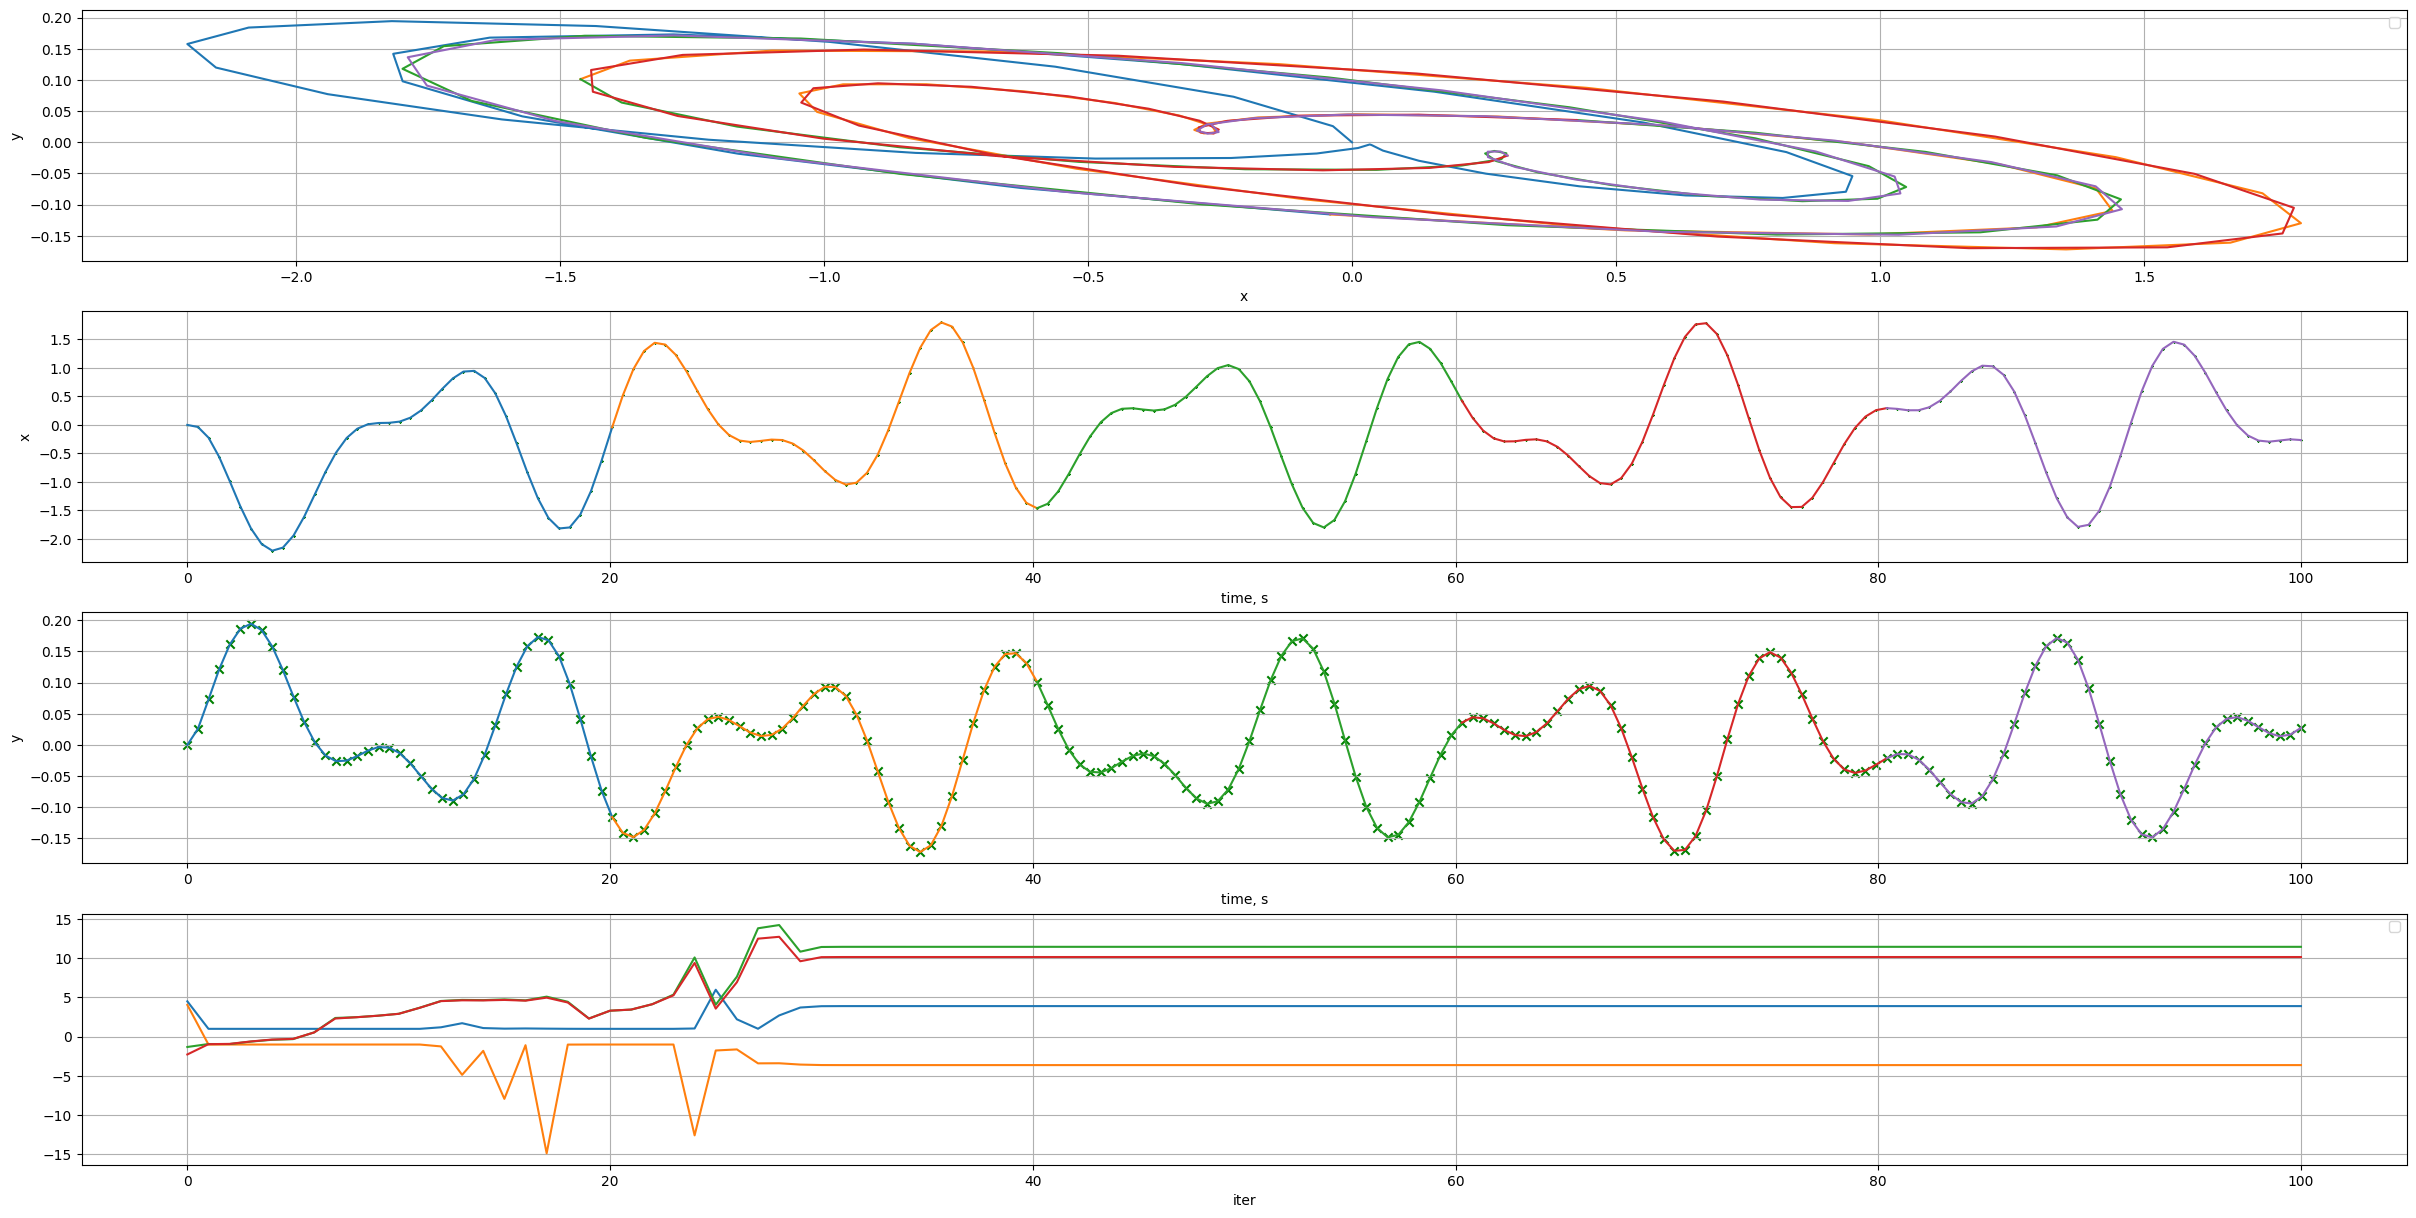

In [124]:

from cvxopt import matrix, solvers

VALIDATION = 0

gamma = np.ones(system.MEAS_LENGTH)
lambda_ = 0.001*0
lambda_reg = 0.001*0
R_norm = 1e8
N_iter = 100

# n = 20
# Qdiff = np.eye(n-1, n, k=1) - np.eye(n-1, n)
# D_diff = np.block([[Qdiff, np.zeros((n-1, n))],  [np.zeros((n-1, n)), Qdiff ]] )

problem = MultipleShooting(system, N_shoot, gamma, use_jax=1)
for state_measured, state_full, t_eval_measurements in zip(state_measured_batches, state_full_batches, t_eval_measurements_batches):
    problem.add_batch(state_full, state_measured, t_eval_measurements)





if(VALIDATION):
    N_iter = 0
else:
    theta_full = problem.make_full_theta(theta)
    THETA_HIST = [np.copy(theta_full[:])]
    
R_HIST = []
delta_theta_estimate = np.zeros_like(theta_full)
for iter in range(N_iter): 
    start = tm_module.time()
    J, R, J_G, R_G = problem.solve(theta_full)
    time_jax_compiled = tm_module.time() - start
    print("t solve" , time_jax_compiled)

    # D = np.pad(D_diff,((0, H.shape[0] - 40), (0, H.shape[0]  - 40)), mode='constant', constant_values=0)
    # Q = D.T@D
    H = J.T@J   
    H_full = np.block([[H, J_G.T], [J_G, np.zeros((J_G.shape[0], J_G.shape[0]))]])
    R_full = np.concatenate((J.T@R, R_G))
    R_norm_curr = np.linalg.norm(R)
    if(R_norm_curr < 1):
        lambda_reg = 0.0001*0

    I_reg = np.zeros(H_full.shape)
    k = J.shape[1]
    I_reg[:k, :k] = np.eye(k)


    # h = np.zeros(2)
    # h[0] = -(0.4 - theta_full[1])
    # h[1] = (0.5 - theta_full[1])
    # G = np.zeros((2, k))
    # G[0][1] = -1
    # G[1][1] = 1

    constrainth = Constrainth(theta_full)
    constrainth.add(0, 1, 100)
    constrainth.add(1, -100, -1)
    G, h = constrainth.get_matrix()

    G = matrix(G)
    h = matrix(h)

    # G = None
    # h = None

    delta_theta_estimate = (np.linalg.inv(H_full + lambda_reg * I_reg+ lambda_*np.diag(np.diag(H_full)))@R_full)[:len(theta_full)] 

    sol = solvers.qp(P = matrix(J.T@J + lambda_reg * np.eye(k) + lambda_*np.diag(np.diag(J.T@J))), 
                     q = matrix(-J.T@R),
                     A = matrix(J_G), b = matrix(R_G),
                     G = G, h = h )
    
    delta_theta_estimate = np.array(sol['x']).flatten()

    theta_full = theta_full + delta_theta_estimate
    # print("theta_full", theta_full)
    print(f'Iter {iter}   --- R {R_norm_curr}')
    THETA_HIST.append(np.copy(theta_full[:]))
    R_HIST.append(R_norm_curr)
    # if(np.abs(R_norm_curr - R_norm) < 1e-6):
    #     print(f'Iter {iter}   --- R {R_norm_curr}')
    #     print("solution converged")
    #     break

    # if(np.linalg.norm(R) - R_norm > 1e1):
    #     print(f'Iter {iter}   --- R {np.linalg.norm(R)}')
    #     print("solution disconverged")
    #     break
    R_norm = R_norm_curr


plot_solution(problem, theta_full, THETA_HIST)

In [99]:
theta_full, THETA_HIST[0]

(array([ 3.84547303e+00, -3.68608748e+00,  1.14345940e+01,  1.01360868e+01,
        -4.47878794e-03, -1.57419864e-05, -3.96775811e-02, -1.15732471e-01,
        -1.46125066e+00,  1.01445922e-01,  4.24362135e-01,  3.57939233e-02,
         2.94832478e-01, -2.13351969e-02]),
 array([-2.51599163, -4.57110574,  3.49913108, -3.98999876,  0.        ,
         0.        , -0.04194234, -0.11571071, -1.46197867,  0.1013825 ,
         0.42584783,  0.03578096,  0.29421473, -0.02128075]))

In [49]:
# theta_my = np.copy(theta_full)
# theta_my[1] = 0.4
# theta_my[:4] = np.array([1.1, 0.4, 0.5, 0.1])
# plot_solution(problem, theta_my, THETA_HIST)

np.float64(9.287767828707684e-07)

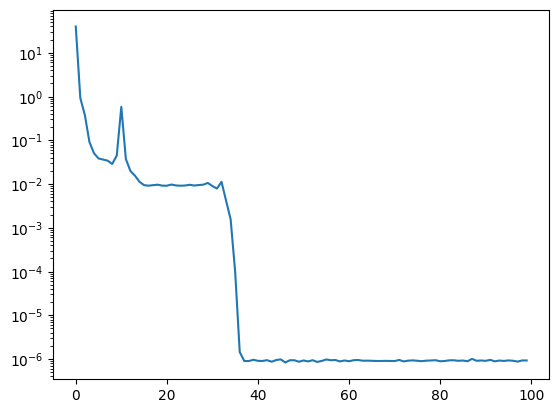

In [118]:
plt.semilogy(R_HIST)
R_HIST[-1]

In [64]:
np.array(h)

array([[0.3],
       [0.5]])

In [101]:
theta_full[:4], theta_true

(array([ 3.84547303, -3.68608748, 11.43459397, 10.13608682]),
 array([ 3.90697911, -3.61844364, 11.46438743, 10.16318852]))

In [75]:
np.array(matrix([[-1.0, 0.0, 0, 0], [0.0, 1.0, 0, 0]]).T)

array([[-1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [ ]:

delta_theta_estimate1 = (np.linalg.inv(H_full + lambda_reg * I_reg+ lambda_*np.diag(np.diag(H_full)))@R_full)[:len(theta_full)] 
sol = solvers.qp(P = matrix(J.T@J + lambda_reg * np.eye(k) + lambda_*np.diag(np.diag(J.T@J))), q = matrix(-J.T@R),
                    A = matrix(J_G), b = matrix(R_G))
delta_theta_estimate = np.array(sol['x']).flatten()

In [28]:
delta_theta_estimate1, delta_theta_estimate

(array([-1.65730526e-04, -1.87494685e-04,  4.78688884e-07,  5.94674272e-07,
         2.79057586e-05, -6.43574306e-08,  3.07811500e-06,  1.94226075e-07,
        -3.83331995e-05,  6.71939972e-07, -6.51734946e-07, -1.13047829e-07,
        -1.07412590e-05,  2.09056164e-07]),
 array([-1.65730528e-04, -1.87494687e-04,  4.78688889e-07,  5.94674278e-07,
         2.79057587e-05, -6.43574322e-08,  3.07811504e-06,  1.94226075e-07,
        -3.83331995e-05,  6.71939972e-07, -6.51734959e-07, -1.13047829e-07,
        -1.07412590e-05,  2.09056164e-07]))